In [1]:
!pip install scikit-learn

In [2]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image as image_loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2023-04-18 15:12:26.694928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-04-18 15:12:30.055046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 15:12:30.081494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 15:12:30.081853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Define hyper parameter

In [5]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3



Batch_Size = 32
lr=1e-2
loss_function = "categorical_crossentropy"
Epochs = 10

Define Paths

In [6]:
#main_path = "datasets/misc/lspd/images/aliakbar"
main_path = "/tf/dataset/cavity_images"
#train_path = main_path + "/train"
#test_path = main_path + "/test"
#validation_path = main_path + "/validation"
checkpoint_filepath = "check_point.h5"
tensorboard_log = "logs"
model_save_path = "."

Dataset Preparation

In [7]:
main_datagen = ImageDataGenerator(
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2],
    validation_split=0.2,
) 

train_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="training",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
test_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="validation",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
Num_Class=train_generator.num_classes
#class_names =  train_generator.class_names
#sample = next(train_generator)
#print(sample[0].shape)


Found 16059 images belonging to 10 classes.
Found 4008 images belonging to 10 classes.


In [32]:
train_generator.next()[0][-1]

array([[[91., 91., 91.],
        [91., 91., 91.],
        [91., 91., 91.],
        ...,
        [86., 86., 86.],
        [86., 86., 86.],
        [86., 86., 86.]],

       [[89., 89., 89.],
        [89., 89., 89.],
        [89., 89., 89.],
        ...,
        [86., 86., 86.],
        [86., 86., 86.],
        [86., 86., 86.]],

       [[89., 89., 89.],
        [89., 89., 89.],
        [89., 89., 89.],
        ...,
        [86., 86., 86.],
        [86., 86., 86.],
        [86., 86., 86.]],

       ...,

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [70., 70., 70.],
        [70., 70., 70.],
        [70., 70., 70.]],

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [70., 70., 70.],
        [70., 70., 70.],
        [70., 70., 70.]],

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [70., 70., 70.],
        [70., 70., 70.],
        [70., 70., 70.]]

In [7]:
for sample in train_generator:
    image = sample[0].astype('uint8')
#    print(image)
    break


Plot somr Datas

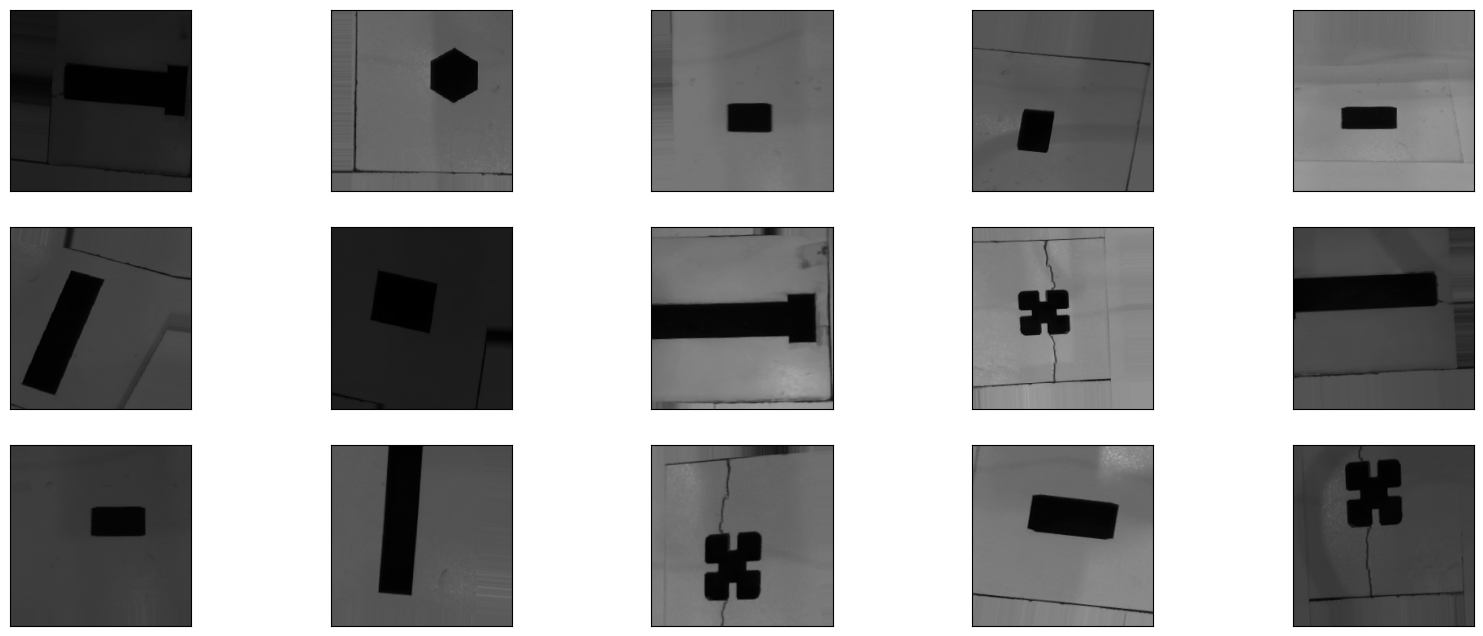

In [8]:
figure = plt.figure(figsize=(20, 8))
for i in range(15) :
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = next(train_generator)[0][-1].astype('uint8')
    #plt.title(class_names[labels[i]])

    ax.imshow(np.squeeze(image))
    

ReduceLROnPlateau = https://keras.io/api/callbacks/reduce_lr_on_plateau/ -> reduce lr when no improvment
EarlyStopping     = https://keras.io/api/callbacks/early_stopping/       -> stop training if no improvment
ModelCheckpoint   = https://keras.io/api/callbacks/model_checkpoint/     -> save checkpoint
TensorBoard       = https://keras.io/api/callbacks/tensorboard/          -> tensorboard

In [9]:
earlystop               = EarlyStopping(patience=10)
tensorboard             = TensorBoard(log_dir=tensorboard_log,histogram_freq=1,update_freq='batch',profile_batch=True ,write_graph=True,write_images=True,write_steps_per_second=True)
checkpoint              = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
callbacks               = [earlystop, learning_rate_reduction,checkpoint,tensorboard]

2023-04-17 07:30:38.988364: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-17 07:30:38.988403: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-17 07:30:38.989967: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1679] Profiler found 1 GPUs
2023-04-17 07:30:39.032857: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-04-17 07:30:39.032995: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


Build Model

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2, EfficientNetV2B0 
import tensorflow as tf

#model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2"
#model = hub.KerasLayer(model_handle, trainable= False)
#type(model)

def model_builder():
    inputs = layers.Input(shape=(Image_Width, Image_Height, Image_Channels))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = hub.KerasLayer(model_handle, trainable= False),
    
    # Freeze the pretrained weights
    #model.trainable = True
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(Num_Class, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy","MeanSquaredError","AUC"]
    )
    return model
model = model_builder()

2023-04-16 15:27:05.634888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 15:27:05.635101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 15:27:05.635259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Start Training

In [12]:

history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // Batch_Size,
    steps_per_epoch=train_generator.samples // Batch_Size,
    callbacks=callbacks
)

Epoch 1/10


2023-04-16 15:27:13.497017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-16 15:27:13.543355: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-16 15:27:13.543389: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-16 15:27:18.113601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-16 15:27:19.338805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-16 15:27:20.259788: I tensorflow/compiler/xla/servic

  2/501 [..............................] - ETA: 30s - loss: 2.3242 - accuracy: 0.3281 - mean_squared_error: 0.0851 - auc: 0.6973    

2023-04-16 15:27:21.436262: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-04-16 15:27:21.438075: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-04-16 15:27:21.481332: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 3304 callback api events and 2564 activity events. 
2023-04-16 15:27:21.499593: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


501/501 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9601 - mean_squared_error: 0.0064 - auc: 0.9939

2023-04-16 15:29:27.723870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


501/501 [==============================] - 171s 326ms/step - loss: 0.1745 - accuracy: 0.9601 - mean_squared_error: 0.0064 - auc: 0.9939 - val_loss: 0.0329 - val_accuracy: 0.9918 - val_mean_squared_error: 0.0014 - val_auc: 0.9989 - lr: 0.0100
Epoch 2/10
501/501 [==============================] - 163s 325ms/step - loss: 0.1066 - accuracy: 0.9832 - mean_squared_error: 0.0029 - auc: 0.9960 - val_loss: 0.0066 - val_accuracy: 0.9973 - val_mean_squared_error: 3.9998e-04 - val_auc: 0.9999 - lr: 0.0100
Epoch 3/10
501/501 [==============================] - 162s 323ms/step - loss: 0.1482 - accuracy: 0.9828 - mean_squared_error: 0.0031 - auc: 0.9948 - val_loss: 0.1311 - val_accuracy: 0.9885 - val_mean_squared_error: 0.0021 - val_auc: 0.9953 - lr: 0.0100
Epoch 4/10
501/501 [==============================] - 161s 322ms/step - loss: 0.1256 - accuracy: 0.9854 - mean_squared_error: 0.0026 - auc: 0.9958 - val_loss: 0.0147 - val_accuracy: 0.9980 - val_mean_squared_error: 3.8013e-04 - val_auc: 0.9994 - lr

Save Models

In [63]:
now = datetime.now()
 
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print(model_save_path+'/'+dt_string+'.h5')
model.save(model_save_path+'/'+dt_string+'.h5')

./16-04-2023_17-59-15.h5


In [11]:
from keras.models import load_model
model = load_model('/tf/PPT/bbox_classification/classification_model.h5')

2023-04-17 07:32:03.723561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 07:32:03.723934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 07:32:03.724148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
#test_path = "/tf/dataset/cavity_images/M20_100_horizontal/M20_100_horizontal_021.jpg"
test_path = "/tf/dataset/cavity_images"

Predict For check data

In [13]:
folders = os.listdir(test_path)

images_path = []
for folder in folders :
    
    for image in os.listdir(test_path+'/'+folder):
        #print(image)
        path = test_path+'/'+folder+'/'+image
        #print(path)
        images_path.append(path)
        

In [14]:
len(images_path)

20067

In [15]:
def image_predict(image_path):
    
    img = image_loader.load_img(image_path,target_size=(224,224))
    img_tensor = image_loader.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)   
    return img_tensor


In [16]:
random.shuffle(images_path)
labels = train_generator.class_indices
print(labels)


{'F20_20_horizontal': 0, 'M20_100_horizontal': 1, 'M20_horizontal': 2, 'M20_vertical': 3, 'M30_horizontal': 4, 'M30_vertical': 5, 'R20_horizontal': 6, 'R20_vertical': 7, 'S40_40_horizontal': 8, 'S40_40_virtical': 9}


In [17]:
labels = dict((v, k) for k, v in labels.items())
print(labels)


{0: 'F20_20_horizontal', 1: 'M20_100_horizontal', 2: 'M20_horizontal', 3: 'M20_vertical', 4: 'M30_horizontal', 5: 'M30_vertical', 6: 'R20_horizontal', 7: 'R20_vertical', 8: 'S40_40_horizontal', 9: 'S40_40_virtical'}


1/1 [==============================] - 0s 37ms/step
<class 'numpy.int64'> 4
1/1 [==============================] - 0s 38ms/step
<class 'numpy.int64'> 6
1/1 [==============================] - 0s 41ms/step
<class 'numpy.int64'> 6
1/1 [==============================] - 0s 39ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 38ms/step
<class 'numpy.int64'> 7
1/1 [==============================] - 0s 39ms/step
<class 'numpy.int64'> 0
1/1 [==============================] - 0s 39ms/step
<class 'numpy.int64'> 2
1/1 [==============================] - 0s 39ms/step
<class 'numpy.int64'> 9
1/1 [==============================] - 0s 38ms/step
<class 'numpy.int64'> 2
1/1 [==============================] - 0s 39ms/step
<class 'numpy.int64'> 6
1/1 [==============================] - 0s 41ms/step
<class 'numpy.int64'> 2
1/1 [==============================] - 0s 42ms/step
<class 'numpy.int64'> 2
1/1 [==============================] - 0s 43ms/step
<class 'numpy.int64'> 4
1/1 [=======

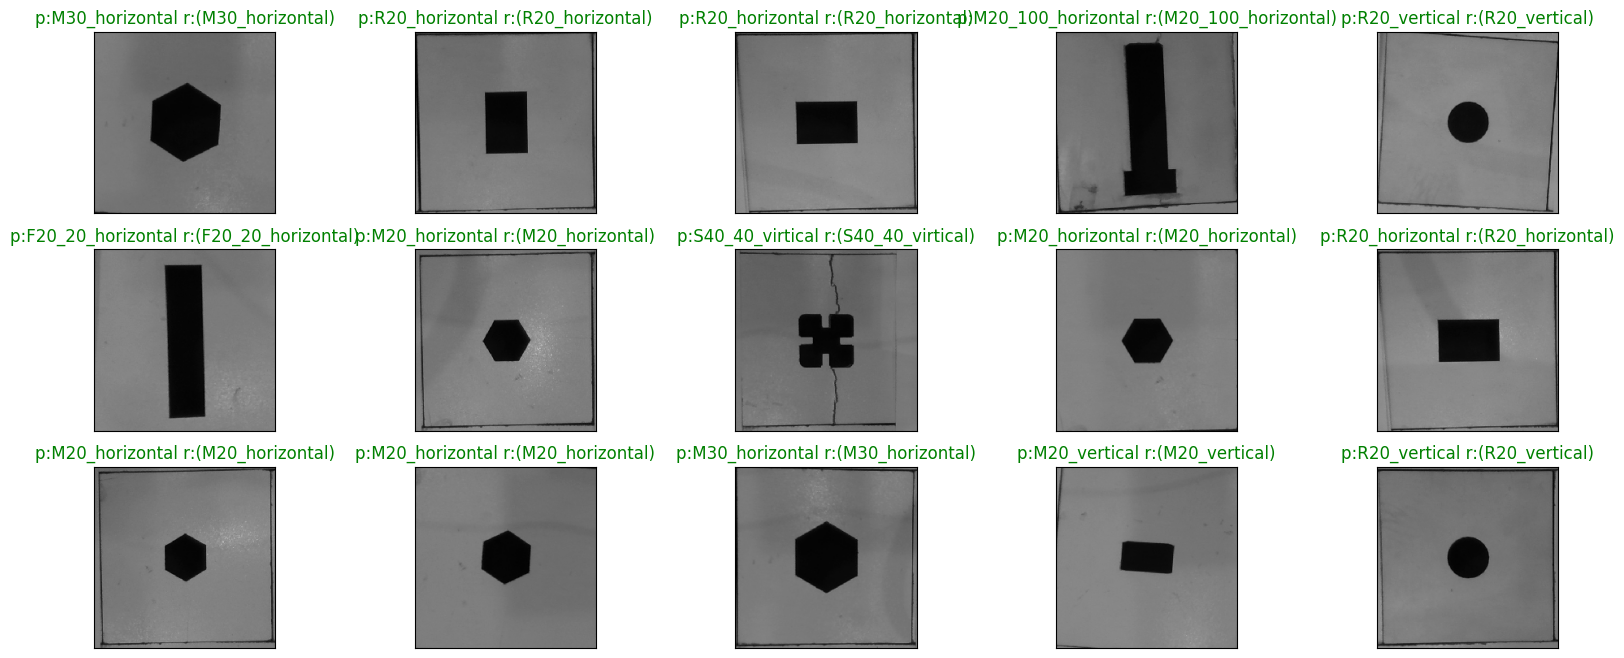

In [23]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i,img_path in enumerate( images_path[0:15]):
    
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    
    # Display each image
    image = image_loader.load_img(img_path, target_size=Image_Size)
    ax.imshow(np.squeeze(image))
    
    image_to_predict = image_predict(img_path)
    predict = np.argmax(model.predict(image_to_predict))
    print(type(predict), predict)
    #true_label = "porn" if '/p_' in img_path else "normal"
    true_label = '_'.join(img_path.split('/')[-1].split('.')[0].split('_')[0:-1])
    #print(true_label)
    ax.set_title(f"p:{labels[predict]} r:({true_label})", color=("green" if true_label == labels[predict] else "red"))
    #ax.set_title("True" if labels[predict] == true_label else f"p:{labels[predict]} r:({true_label})",
    #             color=("green" if true_label == labels[predict] else "red"))

In [ ]:
from keras.models import load_model
del model
model = load_model('25_03_2022.22_11_26.h5')

In [ ]:
y_pred = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
y_test = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2])

In [35]:
labels = {
    0:'porn',
    1:'normal'
}
y_pred = []
y_test = []

labels = dict((v, k) for k, v in labels.items())
for folder in os.listdir("../datasets/storage_disk/h/labled_data/train"):
    items = os.listdir("../datasets/storage_disk/h/labled_data/train/"+folder)
    random.shuffle(items)
    counter = 0
    for item in items:
            image_to_predict = image_predict("../datasets/storage_disk/h/labled_data/train/"+folder+"/"+item)
            predict = np.argmax(model.predict(image_to_predict))
            real_id = 0 if folder=='normal' else 1
            y_pred.append(predict)
            y_test.append(real_id)


2022-07-15 10:09:02.393713: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 0s 16ms/step


KeyboardInterrupt: 

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

NameError: name 'y_test' is not defined